In [1]:
import math
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm.auto import tqdm
from sklearn import metrics
from collections import OrderedDict
torch.manual_seed(914)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
from datasets import load_dataset

timit = load_dataset('timit_asr')

Reusing dataset timit_asr (C:\Users\Yang\.cache\huggingface\datasets\timit_asr\clean\2.0.1\0d9aa986fc12e3ae76626fd6f835256125ec71c3af4680826359e7e8a98a8176)


In [3]:
timit_train_df = timit["train"].to_pandas()
timit_test_df = timit["test"].to_pandas()

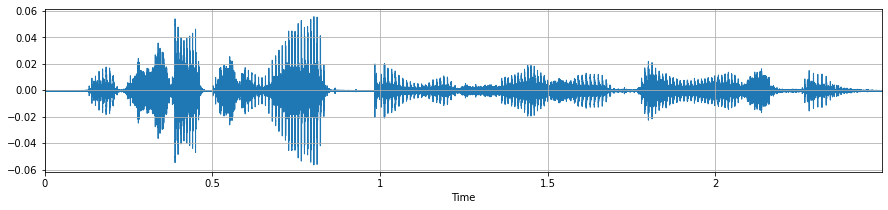

In [4]:
import librosa
import librosa.display

filename = timit_train_df.file[0]
samples, sample_rate = librosa.load(filename, sr=16000)
fig = plt.figure(figsize=(15, 3))
librosa.display.waveplot(samples, sr=sample_rate)
plt.grid()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

timit_df = pd.concat([timit_train_df, timit_test_df], axis=0).reset_index(drop=True)
timit_train_df, timit_test_df = train_test_split(timit_df, test_size=0.2, random_state=914, stratify=timit_df.speaker_id)

In [6]:
timit_train_df = timit_train_df.reset_index(drop=True)
timit_test_df = timit_test_df.reset_index(drop=True)

In [7]:
import random

def generate_segments(sample, windows, num_samples):
    lst = range(len(sample))
    list_size = len(lst)
    indexes = [lst[i:i+windows] for i in range(list_size-windows+1)]
    indexes = random.choices(indexes, k=num_samples)
    sub_lst = [sample[min(idx):max(idx)] for idx in indexes]
    return sub_lst

In [8]:
def padding(arr, max_length):
    padding = np.zeros(max_length)
    padding[:len(arr)] = arr
    return padding

In [9]:
sample_rate = 16000
segments = 10

all_wave, all_label = [], []
for idx in tqdm(range(len(timit_train_df))):
    samples, sample_rate = librosa.load(timit_train_df.file[idx], sr=sample_rate)
    if len(samples) < sample_rate:
        samples = padding(samples, int(sample_rate*1.5))
    samples_segments = generate_segments(samples, windows=sample_rate, num_samples=segments)
    label = timit_train_df.speaker_id[idx]
    all_wave.extend(samples_segments)
    all_label.extend([label]*segments)

In [10]:
all_wave = np.array(all_wave)
all_label = np.array(all_label)
print(all_wave.shape, all_label.shape)

(504000, 15999) (504000,)


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [12]:
import python_speech_features

def compute_mfcc(data, n_mfcc, sr=16000):
    print('Compute MFCC, n_mfcc=' + str(n_mfcc), flush=True)
    all_mfcc = []
    for wav in tqdm(data):
        feature = python_speech_features.mfcc(wav, 
                                              samplerate=sr, 
                                              numcep=n_mfcc, 
                                              nfft=int(sr*0.025))
        all_mfcc.append(feature)
    return np.array(all_mfcc)

In [13]:
all_mfcc = compute_mfcc(all_wave, 20)

Compute MFCC, n_mfcc=20


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(all_mfcc, y, test_size=0.25, random_state=914, stratify=y)

In [15]:
mean_ = np.mean(X_train, axis=0)
std_ = np.std(X_train, axis=0)

In [16]:
X_train = (X_train - mean_) / std_
X_valid = (X_valid - mean_) / std_

In [17]:
class SpeechDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index, :, :]
        y = self.y[index]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return [X, y]

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [18]:
train_dataset = SpeechDataset(X=X_train, y=y_train)
valid_dataset = SpeechDataset(X=X_valid, y=y_valid)

batch_size = 128

train_dataloader = train_dataset.create_dataloader(batch_size=batch_size, shuffle=True)
valid_dataloader = valid_dataset.create_dataloader(batch_size=batch_size, shuffle=False)

In [19]:
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [128, 99, 20]
  y: [128]


In [20]:
import pytorch_lightning as pl
import torch.nn.functional as F
from scipy.special import softmax

class MultiClass(pl.LightningModule):
    """
    Multi-class Classification Engine
    """
    
    learning_rate = 1e-3
    
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        batch, y = batch
        y_hat = self(batch)
        labels_hat = torch.argmax(y_hat, dim=1)
        n_correct_pred = torch.sum(y == labels_hat).item()
        loss = F.cross_entropy(y_hat, y.long())
        return {'loss': loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        train_acc = sum([x['n_correct_pred'] for x in outputs]) / sum(x['n_pred'] for x in outputs)
        self.train_losses.append(avg_loss.detach().cpu().item())
        self.train_accuracies.append(train_acc)

    def validation_step(self, batch, batch_idx):
        batch, y = batch
        y_hat = self(batch)
        loss = F.cross_entropy(y_hat, y.long())
        labels_hat = torch.argmax(y_hat, dim=1)
        n_correct_pred = torch.sum(y == labels_hat).item()
        return {'val_loss': loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = sum([x['n_correct_pred'] for x in outputs]) / sum(x['n_pred'] for x in outputs)
        self.valid_losses.append(avg_loss.detach().cpu().item())
        self.valid_accuracies.append(val_acc)

    def test_step(self, batch, batch_idx):
        batch, y = batch
        y_hat = self(batch)
        loss = F.cross_entropy(y_hat, y.long())
        labels_hat = torch.argmax(y_hat, dim=1)
        n_correct_pred = torch.sum(y == labels_hat).item()

        return {'test_loss': loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        test_acc = sum([x['n_correct_pred'] for x in outputs]) / sum(x['n_pred'] for x in outputs)

    def predict_proba(self, test_dataloader):
        """Prediction Step"""
        # Set model to eval mode
        self.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in tqdm(enumerate(test_dataloader)):
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)
                # Forward pass with inputs
                y_prob = self(x)
                # Store outputs
                y_probs.extend(y_prob.cpu())
                
        return softmax(np.vstack(y_probs), axis=1)

In [21]:
class StatsPool(nn.Module):

    def __init__(self, floor=1e-10, bessel=False):
        super(StatsPool, self).__init__()
        self.floor = floor
        self.bessel = bessel

    def forward(self, x):
        means = torch.mean(x, dim=1)
        _, t, _ = x.shape
        if self.bessel:
            t = t - 1
        residuals = x - means.unsqueeze(1)
        numerator = torch.sum(residuals**2, dim=1)
        stds = torch.sqrt(torch.clamp(numerator, min=self.floor)/t)
        x = torch.cat([means, stds], dim=1)
        return x


class TDNN(nn.Module):

    def __init__(
        self,
        input_dim=23,
        output_dim=512,
        context_size=5,
        stride=1,
        dilation=1,
        batch_norm=True,
        dropout_p=0.0,
        padding=0
    ):
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.padding = padding

        self.kernel = nn.Conv1d(self.input_dim,
                                self.output_dim,
                                self.context_size,
                                stride=self.stride,
                                padding=self.padding,
                                dilation=self.dilation)

        self.nonlinearity = nn.ReLU()
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        self.drop = nn.Dropout(p=self.dropout_p)

    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''
        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(
            self.input_dim, d)

        x = self.kernel(x.transpose(1, 2))
        x = self.nonlinearity(x)
        x = self.drop(x)

        if self.batch_norm:
            x = self.bn(x)
        return x.transpose(1, 2)
    
class XVectors(MultiClass):
    
    def __init__(
        self,
        dropout_p=0.0, 
        n_classes=30
    ):
        super(XVectors, self).__init__()
        self.tdnn1 = TDNN(input_dim=20, context_size=5, padding=math.floor(5/2))
        self.tdnn2 = TDNN(input_dim=512, context_size=5, padding=math.floor(5/2))
        self.tdnn3 = TDNN(input_dim=512, output_dim=1500, context_size=1, padding=math.floor(1/2))
        self.tdnnres1 = TDNN(input_dim=512, context_size=7, padding=math.floor(7/2))
        self.tdnnres2 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.tdnnres3 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.pool = StatsPool()
        self.linear1 = nn.Linear(3000, 512)
        self.linear2 = nn.Linear(512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.nonlinearity = nn.ReLU()
        self.classifier = nn.Linear(512, n_classes)
        
    def forward(self, x):
        # Residual TDNN based Frame-level Feature Extractor
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnnres1(x) + x
        x = self.tdnnres2(x) + x
        x = self.tdnnres3(x) + x
        x = self.tdnn3(x)
        
        # Statistics Pooling
        x = self.pool(x)
        
        # DNN based Segment level Feature Extractor
        x = self.linear1(x)
        x = self.nonlinearity(self.dropout1(self.bn1(x)))
        x = self.linear2(x)
        x = self.nonlinearity(self.dropout2(self.bn2(x)))
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [22]:
model = XVectors(n_classes=len(classes))
trainer = pl.Trainer(gpus=1, deterministic=True, max_epochs=10, num_sanity_val_steps=0, fast_dev_run=False)
trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type        | Params
----------------------------------------------
0  | tdnn1        | TDNN        | 52.7 K
1  | tdnn2        | TDNN        | 1.3 M 
2  | tdnn3        | TDNN        | 772 K 
3  | tdnnres1     | TDNN        | 1.8 M 
4  | tdnnres2     | TDNN        | 263 K 
5  | tdnnres3     | TDNN        | 263 K 
6  | pool         | StatsPool   | 0     
7  | linear1      | Linear      | 1.5 M 
8  | linear2      | Linear      | 262 K 
9  | bn1          | BatchNorm1d | 1.0 K 
10 | bn2          | BatchNorm1d | 1.0 K 
11 | dropout1     | Dropout     | 0     
12 | dropout2     | Dropout     | 0     
13 | nonlinearity | ReLU        | 0     
14 | classifier   | Linear      | 323 K 
----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.503    Total estimated model params size (MB)
C:\U

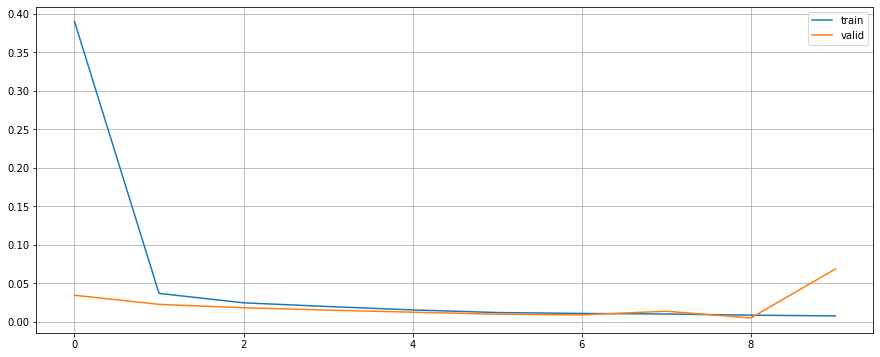

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(model.train_losses)), model.train_losses, label="train")
plt.plot(range(len(model.valid_losses)), model.valid_losses, label="valid")
plt.legend()
plt.grid()
plt.show()

In [24]:
def sliding_window(lst, size):
    return [lst[x:x+size] for x in range(len(lst)-size+1)]

In [25]:
sample_rate = 16000
segments = 10

all_wave_test, all_label_test = [], []
for idx in tqdm(range(len(timit_test_df))):
    samples, sample_rate = librosa.load(timit_test_df.file[idx], sr=sample_rate)
    if len(samples) < sample_rate:
        samples = padding(samples, int(sample_rate*1.5))
    samples_segments = generate_segments(samples, windows=sample_rate, num_samples=segments)
    label = timit_test_df.speaker_id[idx]
    all_wave_test.extend(samples_segments)
    all_label_test.extend([label]*segments)

In [26]:
all_wave_test = np.array(all_wave_test)
all_label_test = np.array(all_label_test)

In [27]:
all_mfcc_test = compute_mfcc(all_wave_test, 20)

Compute MFCC, n_mfcc=20


In [28]:
X_test = all_mfcc_test
y_test = le.transform(all_label_test)

X_test = (X_test - mean_) / std_

In [29]:
batch_size = 128
test_dataset = SpeechDataset(X=X_test, y=y_test)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size, shuffle=False)

In [30]:
y_test_proba = model.predict_proba(test_dataloader)

In [31]:
y_test_proba_final = []
for i in range(y_test_proba.shape[0]//10):
    batch = y_test_proba[10*i:10*i+10, :]
    batch_mean = np.mean(batch, axis=0)
    y_test_proba_final.append(batch_mean)

In [32]:
y_test_proba_final = np.array(y_test_proba_final)
y_test_pred = np.argmax(y_test_proba_final, axis=1)

In [33]:
y_test_ground_truth = le.transform(timit_test_df.speaker_id)

In [34]:
metrics.top_k_accuracy_score(y_test_ground_truth, y_test_proba_final, k=1)

0.9674603174603175